# Eval 3D ResNet as feature extractor (30 animal classes)

In [ ]:
#%%python3 -m pip install --upgrade pip

In [1]:
!pip install mediapipe=='0.10.9'
!pip install opencv-python=='4.8.0.76'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 32.2 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
from utils import VideoDataset, validate_model, train_model, display_frames, display_learning_dynamic, classification_model_metrics

In [4]:
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import json
import os

In [22]:
use_cuda = True
seed = 1

dataloader_dir = "/content/drive/MyDrive/slovo/dataloaders/"

save_path = '/content/drive/MyDrive/slovo/models' #'/content/model'
model_name = 'ResNet_r3d_18_transferFE_Kinetics400'

In [9]:
learning_json = [f for f in os.listdir(save_path) if f[:len(model_name)]==model_name and f[-4:]=='json'][0]
learning_json

'ResNet_r3d_18_transferFE_Kinetics400_loss_acc_dynamic.json'

In [14]:
with open(f'{save_path}/{learning_json}', 'r') as f:
  learning_dyn = json.load(f)

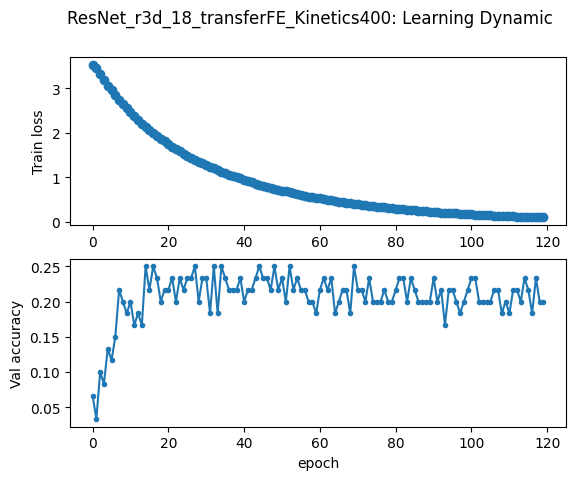

In [18]:
display_learning_dynamic(
    learning_dyn['train_loss_dynamic'],
    learning_dyn['val_accuracy_dynamic'],
    epochs=range(len(learning_dyn['train_loss_dynamic'])),
    model_name=model_name
)

In [19]:
# train_dataloader = torch.load(dataloader_dir + 'color_frames_train_dataloader.pth')
# print(f"Train dataloader contains: {len(train_dataloader)} videos")
val_dataloader = torch.load(dataloader_dir + 'color_frames_val_dataloader.pth')
print(f"Val dataloader contains: {len(val_dataloader)} videos")
test_dataloader = torch.load(dataloader_dir + 'color_frames_test_dataloader.pth')
print(f"Test dataloader contains: {len(test_dataloader)} videos")

Val dataloader contains: 60 videos
Test dataloader contains: 60 videos


In [23]:
use_cuda = use_cuda and torch.cuda.is_available()

if use_cuda:
  for dl in [val_dataloader, test_dataloader]:
    dl.num_workers = 0
    dl.pin_memory = True
  torch.cuda.manual_seed(seed)  # Set the random seed for the current GPU
else:
  torch.manual_seed(seed)

device = torch.device("cuda" if use_cuda else "cpu")

print(f"Device: {device}")

Device: cuda


In [30]:
model_states = [f for f in os.listdir(save_path) if f[:len(model_name)]==model_name and f[-3:]=='pth']
max_val_acc = max([f[-9:-4] for f in model_states])
best_results = [f for f in model_states if f[-9:-4]==max_val_acc]
best_results

['ResNet_r3d_18_transferFE_Kinetics400-15-Val_acc-0.250.pth',
 'ResNet_r3d_18_transferFE_Kinetics400-45-Val_acc-0.250.pth']

In [32]:
# Load 1st best model state

PATH = save_path+'/'+best_results[0]
loaded_path = torch.load(PATH)
resnet = torchvision.models.video.r3d_18()
classes = loaded_path['classes']
num_ftrs = resnet.fc.in_features
n_class = len(classes)
resnet.fc = nn.Linear(num_ftrs, n_class)
resnet.load_state_dict(loaded_path['model_state_dict'])
resnet.to(device)

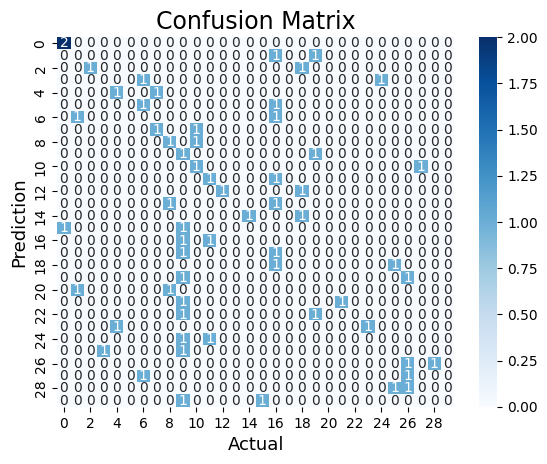

Accuracy=0.23333333333333334; Precision=0.2672222222222222; Recall=0.23333333333333334; F1=0.2491305956344802


In [36]:
classification_model_metrics(resnet, classes, test_dataloader, device)

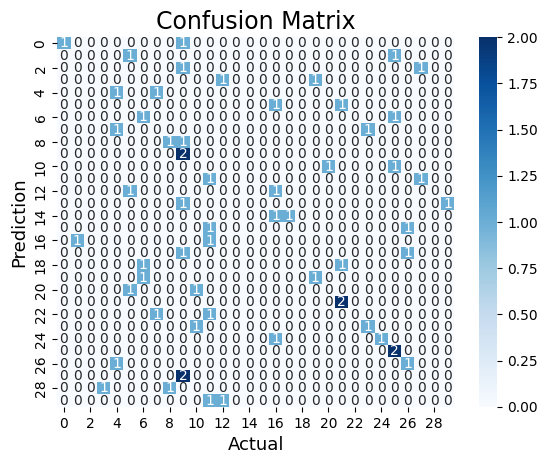

Accuracy=0.25; Precision=0.19407407407407407; Recall=0.25; F1=0.21851542952460384


In [37]:
classification_model_metrics(resnet, classes, val_dataloader, device)

In [40]:
loaded_path.keys()

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'classes'])

In [ ]:
# Load 2d best model state

PATH2 = save_path+'/'+best_results[1]
loaded_path2 = torch.load(PATH2)
classes2 = loaded_path2['classes']
n_class2 = len(classes2)
resnet2 = torchvision.models.video.r3d_18()
num_ftrs2 = resnet2.fc.in_features
resnet2.fc = nn.Linear(num_ftrs2, n_class2)
resnet2.load_state_dict({k.replace('module.',''):v for k,v in loaded_path['model_state_dict'].items()})
resnet2.to(device)

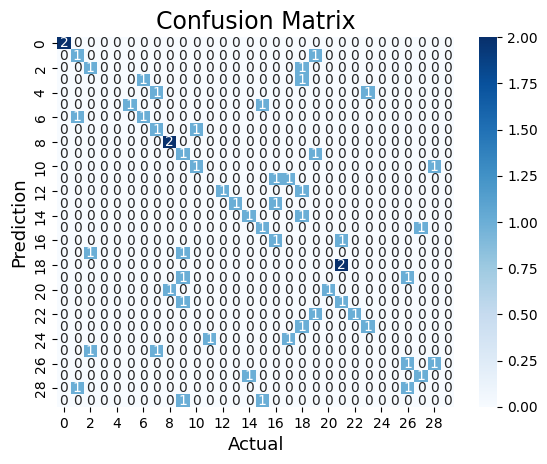

Accuracy=0.36666666666666664; Precision=0.3872222222222222; Recall=0.36666666666666664; F1=0.37666421026774743


In [54]:
classification_model_metrics(resnet2, classes, test_dataloader, device)

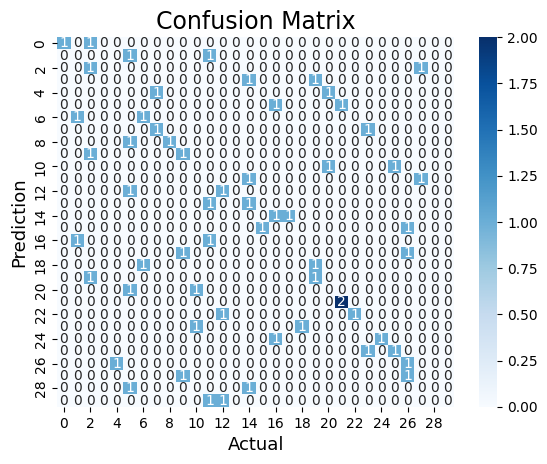

Accuracy=0.25; Precision=0.2888888888888889; Recall=0.25; F1=0.26804123711340205


In [55]:
classification_model_metrics(resnet2, classes, val_dataloader, device)